In [1]:
import confirm.outlaw.nb_util

confirm.outlaw.nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import scipy.special
import confirm.mini_imprint.grid as berrylibgrid
import confirm.mini_imprint.binomial as binomial

# grid_info, sim_info, bound_info = np.load("output_berry3d_hi3.npy", allow_pickle=True)
# grid_info, sim_info, bound_info = np.load("../../output_berry3d_0_1000.npy", allow_pickle=True)
grid_info, sim_info, bound_info = np.load("output_berry4d_0_1000000.npy", allow_pickle=True)

(theta, theta_tiles, tile_radii, corners, null_truth) = grid_info
(sim_sizes, typeI_sum, typeI_score) = sim_info
(total_gp, d0_gp, d0u_gp, d1w_gp, d1uw_gp, d2uw_gp) = bound_info

In [2]:
n_arms = theta_tiles.shape[1]
n_arm_samples = 35
null_hypos = [
    berrylibgrid.HyperPlane(-np.identity(n_arms)[i], -scipy.special.logit(0.1))
    for i in range(n_arms)
]
tree = scipy.spatial.KDTree(theta_tiles)


def eval_bound(eval_pts):
    dist, idx = tree.query(eval_pts, k=2**n_arms)
    tile_idx = np.full(eval_pts.shape[0], -1, dtype=int)
    eval_null = np.empty((eval_pts.shape[0], len(null_hypos)), dtype=bool)
    for d, H in enumerate(null_hypos):
        boundary_dist = eval_pts.dot(H.n) - H.c
        eval_null[:, d] = boundary_dist >= 0
    for i in range(2**n_arms):
        # We choose a tile if the hypotheses all match and the tile has not
        # been assigned yet. The result is that an evaluation point is assigned
        # to the tile it is closest to that matches all hypotheses.
        select = (null_truth[idx[:, i]] == eval_null).all(axis=1) & (tile_idx == -1)
        tile_idx[select] = idx[select, i]
    # assert(np.all((null_truth[tile_idx] == eval_null).all(axis=1)))
    reduced_tile_idx = tile_idx[tile_idx != -1]

    out_arrs = binomial.upper_bound(
        theta_tiles[reduced_tile_idx],
        tile_radii[reduced_tile_idx],
        eval_pts[tile_idx != -1, None, :],
        sim_sizes[reduced_tile_idx],
        n_arm_samples,
        typeI_sum[reduced_tile_idx],
        typeI_score[reduced_tile_idx],
    )
    full_out_arrs = []
    for a in out_arrs:
        a_full = np.full(eval_pts.shape[0], np.nan)
        a_full[tile_idx != -1] = a
        full_out_arrs.append(a_full)
    return full_out_arrs


In [3]:
theta_range = (-3.5, 1.0, 10)
typeI_range = (0, np.max(typeI_sum / sim_sizes))
typeI_range, theta_range


((0, 0.300906), (-3.5, 1.0, 10))

In [4]:
typeI_range = (0, 0.55)


In [5]:
def set_domain(cbar_target, skipx=False, skipy=False, cbar=True, cbar_label=True):
    if cbar:
        cbar = plt.colorbar(cbar_target)
        if cbar_label:
            cbar.set_label("% Type I error upper bound")
    if skipx:
        plt.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    else:
        plt.xlabel(r"$\theta_1$")
        plt.xticks(np.linspace(*theta_range))
    if skipy:
        plt.tick_params(
            axis="y", which="both", left=False, right=False, labelleft=False
        )
    else:
        plt.ylabel(r"$\theta_2$")
        plt.yticks(np.linspace(*theta_range))
    plt.axvline(x=scipy.special.logit(0.1), color="k", linestyle="-")
    plt.axhline(y=scipy.special.logit(0.1), color="k", linestyle="-")


def fig1(cmap=None, n_contours=11, **kwargs):
    t0 = scipy.special.logit(0.1) - 0.001
    n1 = 500
    n2 = n1
    t1 = np.linspace(*theta_range[:2], n1)
    t2 = np.linspace(*theta_range[:2], n2)
    t12 = np.stack(np.meshgrid(t1, t2, indexing="ij"), axis=-1)
    eval_pts = np.concatenate([np.full((n1, n2, 1), t0), t12], axis=-1)
    eval_pts = eval_pts.reshape((-1, n_arms))

    bound = eval_bound(eval_pts)

    eval_pts_3d = eval_pts.reshape((n1, n2, 3))
    simple_slice(eval_pts_3d, bound, **kwargs)


def simple_slice(eval_pts_3d, bound, cmap=None, n_contours=12, **kwargs):
    n1, n2 = eval_pts_3d.shape[:2]

    x = eval_pts_3d[:, :, 1]
    y = eval_pts_3d[:, :, 2]
    z = bound[0].reshape((n1, n2))
    levels = np.linspace(*typeI_range, n_contours) * 100

    cbar_target = plt.contourf(x, y, z * 100, levels=levels, extend="both", cmap=cmap)
    plt.contour(
        x,
        y,
        z * 100,
        levels=levels,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        extend="both",
    )
    set_domain(cbar_target, **kwargs)
    return cbar_target


fig1()
plt.show()


ValueError: cannot reshape array of size 187500 into shape (500,500)

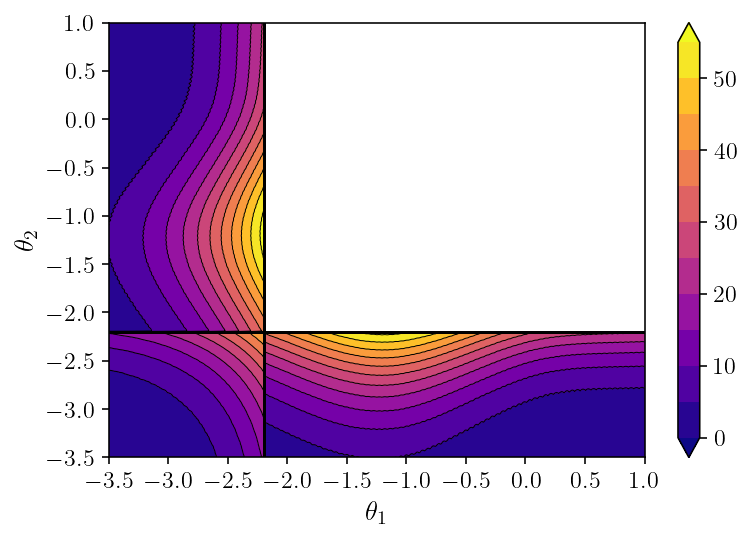

In [8]:
max_theta = theta_tiles[np.argmax(total_gp), :]


def fig2(cmap=None, n_contours=11, **kwargs):
    t0 = max_theta[0]
    n1 = 500
    n2 = n1
    t1 = np.linspace(*theta_range[:2], n1)
    t2 = np.linspace(*theta_range[:2], n2)
    t12 = np.stack(np.meshgrid(t1, t2, indexing="ij"), axis=-1)
    eval_pts = np.concatenate([np.full((n1, n2, 1), t0), t12], axis=-1)
    eval_pts = eval_pts.reshape((-1, n_arms))

    bound = eval_bound(eval_pts)

    eval_pts_3d = eval_pts.reshape((n1, n2, 3))
    simple_slice(eval_pts_3d, bound, **kwargs)


fig2()
plt.show()


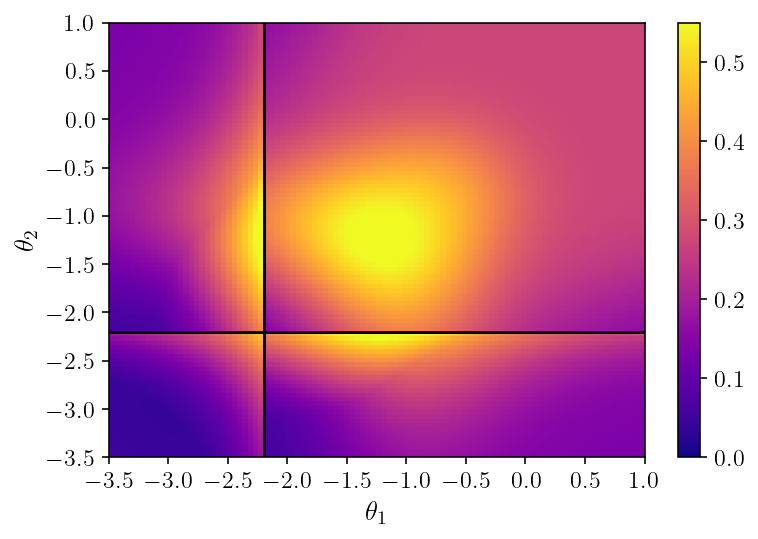

In [73]:
def fig3_data():
    t2_unique = np.unique(theta_tiles[:, 2])
    t1t2_pts = []
    worst_bound = []
    worst_theta = []
    for t1 in t2_unique:
        for t2 in t2_unique:
            select = (theta_tiles[:, 1] == t1) & (theta_tiles[:, 2] == t2)
            worst_idx = np.argmax(total_gp[select])
            worst_theta.append(theta_tiles[select][worst_idx])
            t1t2_pts.append((t1, t2))
            worst_bound.append(total_gp[select][worst_idx])

    grid_shape = t2_unique.shape[0], t2_unique.shape[0]
    t1t2_pts = np.array(t1t2_pts).reshape((*grid_shape, 2))
    worst_bound = np.array(worst_bound).reshape(grid_shape)
    worst_theta = np.array(worst_theta).reshape((*grid_shape, 3))
    return t1t2_pts, worst_bound, worst_theta


fig3_t1t2_pts, fig3_worst_bound, fig3_worst_theta = fig3_data()


def fig3(**kwargs):

    cbar_target = plt.pcolor(
        fig3_t1t2_pts[..., 0],
        fig3_t1t2_pts[..., 1],
        fig3_worst_bound,
        vmin=typeI_range[0],
        vmax=typeI_range[1],
    )
    set_domain(cbar_target, **kwargs)


fig3()
plt.show()
# cbar_target = plt.tripcolor(t1t2_pts[...,0].ravel(), t1t2_pts[...,1].ravel(), worst_bound.ravel())


In [74]:
u1s = theta_tiles.sum(axis=-1) / n_arms
u2s_idx = np.argmax(theta_tiles - scipy.special.logit(0.1), axis=-1)
u2s = theta_tiles[np.arange(theta_tiles.shape[0]), u2s_idx] - scipy.special.logit(0.1)

u1_ordering = np.argsort(u1s)
u1dist = np.append(True, np.diff(u1s[u1_ordering]))
u1_unique = u1s[u1_ordering[u1dist > 1e-10]]

u2_ordering = np.argsort(u2s)
u2dist = np.append(True, np.diff(u2s[u2_ordering]))
u2_unique = u2s[u2_ordering[u2dist > 1e-10]]


In [75]:
u1u2_pts = []
worst_bound = []
for u1v in u1_unique:
    # TODO: SHOULD NOT USE EQUALITY!!
    u1_select = np.abs(u1s - u1v) < 1e-10
    for u2v in np.unique(u2s[u1_select]):
        select = u1_select & (u2s == u2v)
        worst_idx = np.argmax(total_gp[select])
        worst_theta = theta_tiles[select][worst_idx]
        u1u2_pts.append((u1v, u2v))
        worst_bound.append(total_gp[select][worst_idx])
u1u2_pts = np.array(u1u2_pts)
worst_bound = np.array(worst_bound)


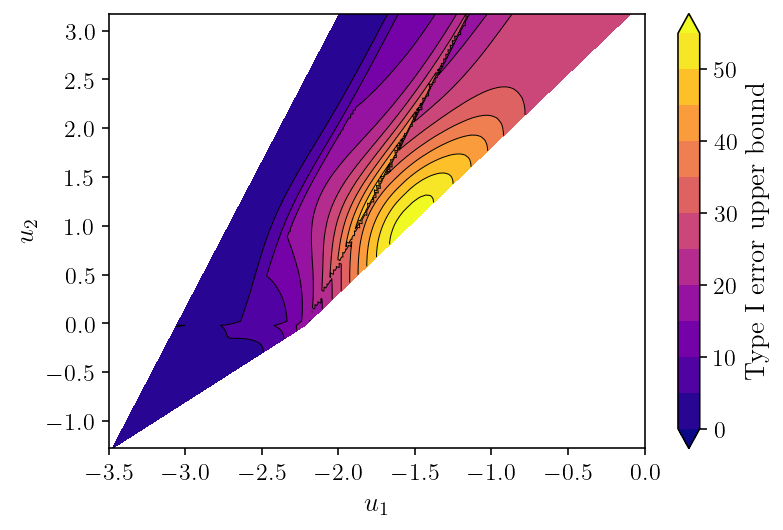

In [76]:
def fig4(cbar=True, skipx=False, skipy=False):
    x = u1u2_pts[..., 0]
    y = u1u2_pts[..., 1]
    z = worst_bound
    levels = np.linspace(*typeI_range, 12) * 100
    # cbar_target = plt.tripcolor(x, y, z * 100)
    cbar_target = plt.tricontourf(x, y, z * 100, levels=levels, extend="both")
    plt.tricontour(
        x,
        y,
        z * 100,
        levels=levels,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        extend="both",
    )
    if cbar:
        cbar = plt.colorbar(cbar_target)
        cbar.set_label("Type I error upper bound")

    if skipx:
        plt.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    else:
        plt.xlabel(r"$u_1$")
        plt.xticks(np.linspace(-3.5, 0.0, 8))
    if skipy:
        plt.tick_params(
            axis="y", which="both", left=False, right=False, labelleft=False
        )
    else:
        plt.ylabel(r"$u_2$")
        plt.yticks(np.linspace(-1, 3, 9))
    return cbar_target


fig4()
plt.show()


\begin{align}
u_1 &= (\theta_1 + \theta_2 + \theta_3 + \theta_4)/4.0\\
u_2 &= max(\theta_i - logit(p_1))
\end{align}


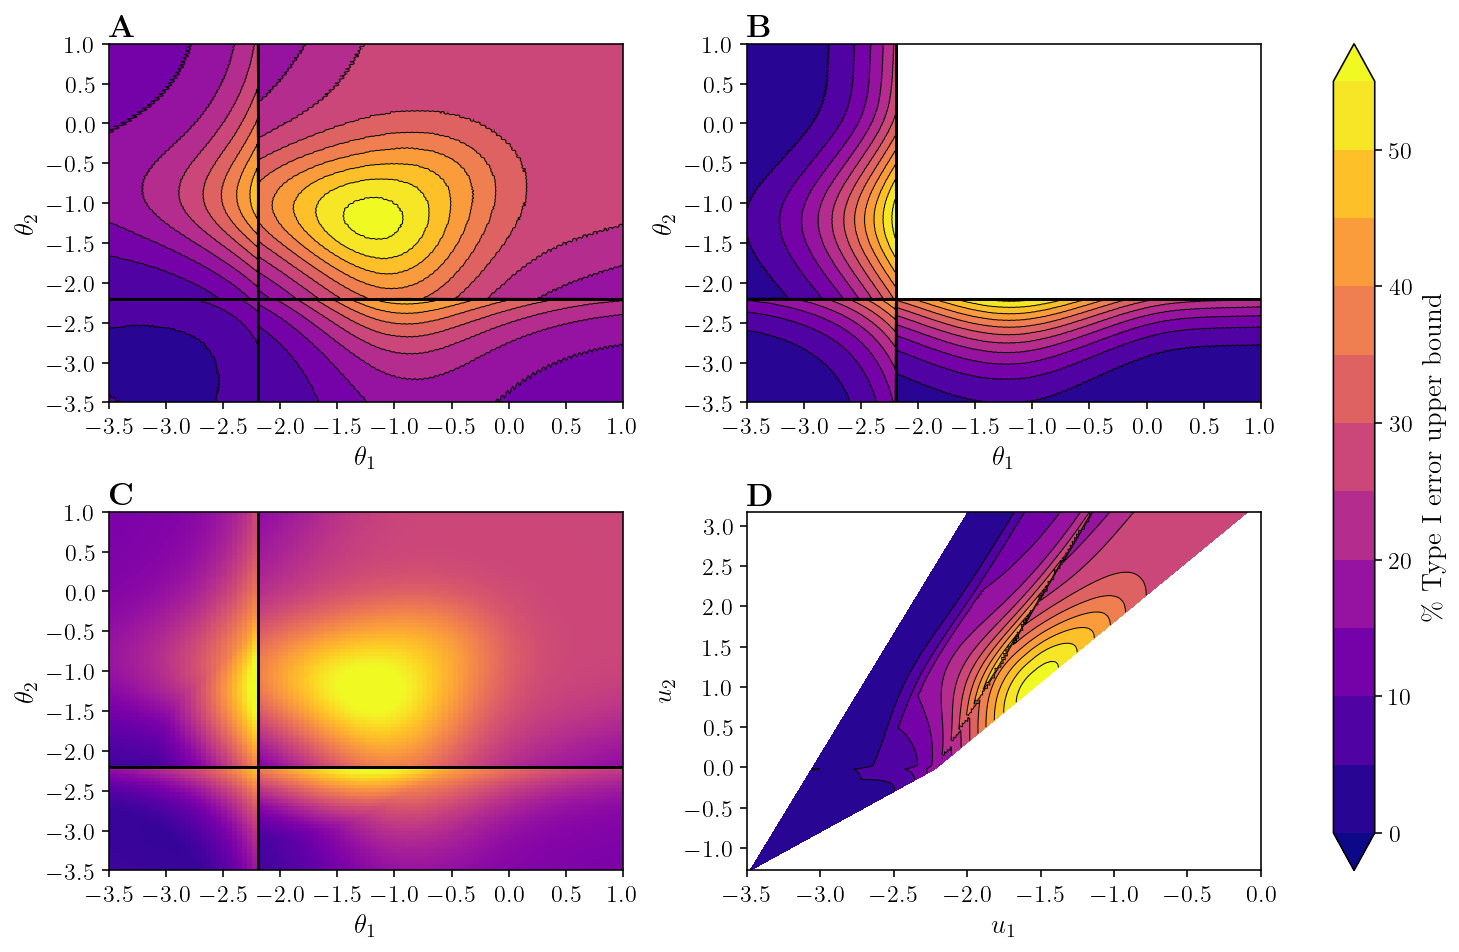

In [82]:
ratio = 8.5 / 5.5
h = 6.5
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(ratio * h, h), constrained_layout=True
)

plt.subplot(2, 2, 1)
cbar_target = fig1(cbar=False)
plt.text(-3.5, 1.1, "$\mathbf{A}$", fontsize=16)

plt.subplot(2, 2, 2)
fig2(cbar=False)
plt.text(-3.5, 1.1, "$\mathbf{B}$", fontsize=16)

plt.subplot(2, 2, 3)
fig3(cbar=False)
plt.text(-3.5, 1.1, "$\mathbf{C}$", fontsize=16)

plt.subplot(2, 2, 4)
cbar_target = fig4(cbar=False)
plt.text(-3.5, 3.25, "$\mathbf{D}$", fontsize=16)

cbar = fig.colorbar(cbar_target, ax=axes.ravel().tolist(), label="\% Type I error upper bound")

plt.show()
